## Load Data

In [1]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(2),
    transforms.Normalize((0.5,), (0.5,)),
])

train_set = datasets.MNIST(
    root="data",
    transform=transform,
    train=True,
    download=True
)
train_loader = DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True
)

test_set = datasets.MNIST(
    root="data",
    transform=transform,
    train=False,
    download=True
)
test_loader = DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=False
)

## Define Net

In [2]:
from torch import nn
from pathlib import Path

model_dir = Path('models')
model_dir.mkdir(exist_ok=True)


def flatten_size(sz):
    # tensor size: [batch, channel, height, width]
    # we need `channel * height * width``
    per_size = sz.size()[1:]
    res = 1
    for i in per_size:
        res *= i
    return res


class SimpleFC(nn.Module):
    NAME = "fc"

    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(23 * 12, 92),
            nn.ReLU(),
            nn.Linear(92, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
        )

    def forward(self, x):
        x = x.view(-1, flatten_size(x))
        x = self.fc(x)
        return x


class SimpleCNN(nn.Module):
    NAME = "cnn"

    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(stride=2, kernel_size=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16 * 16 * 128, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, flatten_size(x))
        x = self.fc(x)
        return x


class LeNet(nn.Module):
    NAME = "lenet"

    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16 * 6 * 6, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, flatten_size(x))
        x = self.fc(x)
        return x


class AlexNet(nn.Module):
    NAME = "alexnet"

    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(5),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Linear(256 * 4 * 1, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 64),
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, flatten_size(x))
        x = self.fc(x)
        return x


Net = SimpleCNN

## Train

In [3]:
import torch

net = Net().cuda()
model_path = model_dir / '{}.pth'.format(net.NAME)
cost = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(net.parameters())
epochs = 5

epochs_list = []
accuracies_list = []
for epoch in range(epochs):
    running_loss = 0.0
    total = 0
    correct = 0
    for data in train_loader:
        # get the inputs; data is a list of [inputs, labels]
        inputs = data[0].cuda()
        labels = data[1].cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)
        # print(outputs.size())
        # break

        # backward + optimize
        loss = cost(outputs, labels)
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item()
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
    print('Net: {}, Epoch: {}/{}, Average Loss: {:.3f}, Train Accuracy: {:.3f}'.format(
        net.NAME, epoch + 1, epochs, running_loss / total, correct / total))
    epochs_list.append(epoch + 1)
    accuracies_list.append(correct / total)

Net: cnn, Epoch: 1/5, Average Loss: 0.001, Train Accuracy: 0.952
Net: cnn, Epoch: 2/5, Average Loss: 0.000, Train Accuracy: 0.986
Net: cnn, Epoch: 3/5, Average Loss: 0.000, Train Accuracy: 0.989
Net: cnn, Epoch: 4/5, Average Loss: 0.000, Train Accuracy: 0.992
Net: cnn, Epoch: 5/5, Average Loss: 0.000, Train Accuracy: 0.994


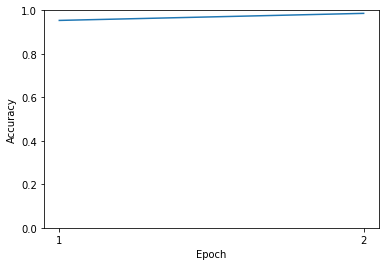

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

# statistical chart
plt.plot(epochs_list, accuracies_list)
plt.ylabel('Accuracy')
plt.ylim((0, 1))
plt.xlabel('Epoch')
plt.xticks(epochs_list)
plt.show()

# save model
torch.save(net.state_dict(), model_path)

## Test

In [ ]:
import torch

# load net
net = Net().cuda()
model_path = model_dir / '{}.pth'.format(net.NAME)
net.load_state_dict(torch.load(model_path))
print('Net loaded')

# test
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy: {} / {} = {}'.format(correct, total, correct / total))

Net loaded
Accuracy: 9870 / 10000 = 0.987


## Test Custom Data

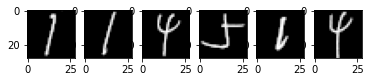

Net loaded
Predict: [1, 1, 4, 5, 1, 1]


In [ ]:
from pathlib import Path
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import torch

custom_dir = Path('custom_data')
data_dir = custom_dir / '1'

# read images
imgs = [(int(i.stem), i) for i in data_dir.glob('*.png')]
imgs.sort()
imgs = [Image.open(i[1]) for i in imgs]

# echo images
fig, axs = plt.subplots(1, len(imgs))
for img, ax in zip(imgs, axs):
    ax.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

# convert to tensor
imgs = torch.stack([transform(i) for i in imgs])

# load net
net = Net().cuda()
model_path = model_dir / '{}.pth'.format(net.NAME)
net.load_state_dict(torch.load(model_path))
print('Net loaded')

# exec
with torch.no_grad():
    outputs = net(imgs.cuda())
    _, predicted = torch.max(outputs.data, 1)
print("Predict: {}".format(predicted.tolist()))

## Test Custom Data with Pytorch Dataset & DataLoader

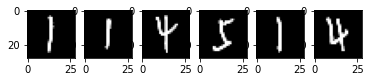

Net loaded
Predict: [1, 1, 4, 5, 1, 4]


In [ ]:
from pathlib import Path
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

custom_dir = Path('custom_data')
data_dir = custom_dir / '2'

# read images
imgs = [(int(i.stem), i) for i in data_dir.glob('*.png')]
imgs.sort()
imgs = [Image.open(i[1]) for i in imgs]

# echo images
fig, axs = plt.subplots(1, len(imgs))
for img, ax in zip(imgs, axs):
    ax.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()


# Dataset
class CustomTestDataset(Dataset):
    def __init__(self):
        self.data = []
        for img in imgs:
            image = transform(img)
            label = ''
            self.data.append((image, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]


# DataLoader
customTestDataset = CustomTestDataset()
customTestDataLoader = DataLoader(
    dataset=customTestDataset,
    batch_size=2,
    pin_memory=True,
    shuffle=False
)

# load net
net = Net().cuda()
model_path = model_dir / '{}.pth'.format(net.NAME)
net.load_state_dict(torch.load(model_path))
print('Net loaded')

# exec
res = []
with torch.no_grad():
    for data in customTestDataLoader:
        images = data[0].cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        res.extend(predicted.tolist())
print("Predict: {}".format(res))